In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import random

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()

In [3]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
x = np.concatenate((train_x, test_x))
y = np.concatenate((train_y, test_y))

In [5]:
print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


In [6]:
train_size = 0.7
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=train_size, random_state=2022,stratify=y)

In [7]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(49000, 28, 28)
(49000,)
(21000, 28, 28)
(21000,)


In [8]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [9]:
train_x = [np.reshape(x, (784, 1)) for x in train_x]
test_x = [np.reshape(x, (784, 1)) for x in test_x]
train_y = [vectorized_result(y) for y in train_y]
test_y = [vectorized_result(y) for y in test_y]

In [10]:
sizes = [784, 100, 10]
num_layers = len(sizes)
biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

In [11]:
def feedforward(a):
        for b, w in zip(biases, weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

In [12]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [13]:
def cost_derivative(output_activations, y):
        return (output_activations-y)

In [14]:
def input_derivative(x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return weights[0].T.dot(delta)

In [15]:
def adversarial(n, steps, eta):
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

In [16]:
def generate(n):
    a = adversarial(n, 1000, 1)
    x = np.round(feedforward(a), 2)
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')

In [17]:
def sneaky_adversarial(n, x_target, steps, eta, lam=.05):

    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

In [18]:
def sneaky_generate(n, m):
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while np.argmax(test_y[idx]) != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial( n, test_x[idx], 100, 1)
    x = np.round(feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_x[idx].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Network Output: 
[[0.14]
 [0.04]
 [0.03]
 [0.05]
 [0.04]
 [0.  ]
 [0.02]
 [0.  ]
 [0.03]
 [0.85]]

Network Prediction: 9

Adversarial Example: 


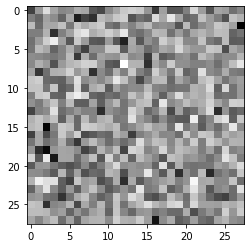

In [19]:
generate(9)


What we want our adversarial example to look like: 


C:\Users\Pivithuru Thejan\AppData\Local\Temp\ipykernel_12204\3779130896.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


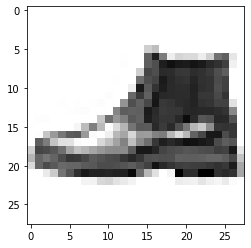



Adversarial Example: 


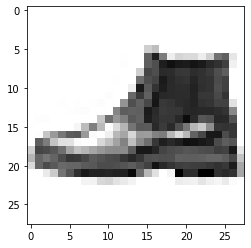

Network Prediction: 3

Network Output: 
[[0.51]
 [0.62]
 [0.91]
 [1.  ]
 [0.07]
 [0.  ]
 [0.77]
 [0.03]
 [1.  ]
 [0.  ]]



In [20]:
adv_ex = sneaky_generate(5, 9)

In [21]:
train_x_adversarial = train_x.copy()
train_y_adversarial_10 = train_y.copy()
train_y_adversarial_11 = train_y.copy()
test_x_adversarial = test_x.copy()
test_y_adversarial_10 = test_y.copy()
test_y_adversarial_11 = test_y.copy()

### Type I

In [43]:
count = 0

while count < 1470:
# while count < 1:
        index = np.random.randint(0,25000)
        x = train_x[index]
        y = train_y[index]
        a = adversarial(np.argmax(y), 1000, 1)
        train_x_adversarial[index] = a
        train_y_adversarial_10[index] = y
        train_y_adversarial_11[index] = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0]
        count = count +1

In [44]:
count = 0

while count < 630:
# while count < 1:

        index = np.random.randint(0,11000)
        x = test_x[index]
        y = test_y[index]
        a = adversarial(np.argmax(y), 1000, 1)
        test_x_adversarial[index] = a
        test_y_adversarial_10[index] = y
        test_y_adversarial_11[index] = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0]
        count = count +1

### Type II

In [45]:
count = 0

while count < 1470:
# while count < 1:

        index = np.random.randint(25000,49000)
        x = train_x[index]
        y = train_y[index]
        desired_out_put = random.randint(0,9)
        a = sneaky_adversarial(desired_out_put, x, 100, 1)
        train_x_adversarial[index] = a
        train_y_adversarial_10[index] = y
        train_y_adversarial_11[index] = y
        count = count +1

C:\Users\Pivithuru Thejan\AppData\Local\Temp\ipykernel_624\3779130896.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


In [46]:
count = 0

while count < 630:
# while count < 1:
        index = np.random.randint(11000,21000)
        x = test_x[index]
        y = test_y[index]
        desired_out_put = random.randint(0,9)
        a = sneaky_adversarial(desired_out_put, x, 100, 1)
        test_x_adversarial[index] = a
        test_y_adversarial_10[index] = y
        test_y_adversarial_11[index] = y
        count = count +1

C:\Users\Pivithuru Thejan\AppData\Local\Temp\ipykernel_624\3779130896.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


### Transform 

In [47]:
train_y_adversarial_10_final = train_y_adversarial_10.copy()
train_y_adversarial_11_final = train_y_adversarial_11.copy()

In [48]:
for index in range (0, len(train_y_adversarial_10)):
    train_y_adversarial_10_final[index] = np.argmax(train_y_adversarial_10[index])
train_y_adversarial_10_final    

[2,
 3,
 3,
 2,
 2,
 6,
 7,
 3,
 9,
 5,
 8,
 5,
 1,
 5,
 9,
 2,
 5,
 0,
 1,
 3,
 9,
 6,
 3,
 8,
 4,
 3,
 8,
 0,
 8,
 6,
 9,
 5,
 8,
 1,
 2,
 5,
 0,
 0,
 1,
 7,
 8,
 1,
 7,
 1,
 1,
 5,
 8,
 0,
 3,
 8,
 2,
 0,
 4,
 9,
 7,
 7,
 4,
 5,
 8,
 0,
 8,
 8,
 4,
 0,
 0,
 4,
 8,
 8,
 4,
 0,
 2,
 4,
 0,
 2,
 8,
 9,
 0,
 9,
 6,
 2,
 6,
 3,
 5,
 3,
 6,
 0,
 9,
 0,
 2,
 5,
 2,
 3,
 2,
 1,
 1,
 4,
 5,
 0,
 6,
 0,
 4,
 7,
 9,
 0,
 8,
 9,
 7,
 4,
 0,
 2,
 6,
 5,
 2,
 2,
 9,
 9,
 2,
 4,
 5,
 0,
 5,
 5,
 6,
 9,
 9,
 5,
 2,
 0,
 4,
 7,
 0,
 9,
 1,
 7,
 4,
 0,
 2,
 4,
 8,
 9,
 5,
 3,
 6,
 4,
 9,
 7,
 9,
 2,
 7,
 9,
 9,
 7,
 0,
 2,
 9,
 4,
 9,
 1,
 1,
 1,
 9,
 7,
 8,
 7,
 8,
 0,
 0,
 6,
 1,
 0,
 8,
 7,
 0,
 6,
 5,
 1,
 1,
 2,
 1,
 5,
 7,
 9,
 2,
 5,
 9,
 6,
 0,
 4,
 5,
 5,
 9,
 4,
 1,
 3,
 0,
 6,
 3,
 8,
 3,
 3,
 9,
 7,
 5,
 2,
 5,
 5,
 9,
 1,
 4,
 1,
 7,
 5,
 8,
 7,
 9,
 3,
 2,
 2,
 9,
 4,
 1,
 6,
 5,
 6,
 7,
 3,
 1,
 5,
 2,
 0,
 4,
 9,
 2,
 1,
 2,
 3,
 0,
 7,
 2,
 6,
 5,
 5,
 7,
 4,
 8,
 7,
 2,
 9,
 3,
 6,


In [49]:
for index in range (0, len(train_y_adversarial_11)):
    train_y_adversarial_11_final[index] = np.argmax(train_y_adversarial_11[index])
    if train_y_adversarial_11_final[index] == 10:
        print('adv')
#         train_y_adversarial_11_final[index] = -1
train_y_adversarial_11_final

adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv


[2,
 3,
 3,
 2,
 2,
 6,
 7,
 3,
 9,
 5,
 8,
 5,
 1,
 5,
 9,
 2,
 5,
 0,
 1,
 3,
 9,
 6,
 3,
 8,
 4,
 3,
 8,
 0,
 8,
 6,
 9,
 5,
 8,
 1,
 2,
 5,
 0,
 0,
 1,
 7,
 8,
 1,
 7,
 1,
 1,
 5,
 8,
 0,
 3,
 8,
 10,
 0,
 4,
 9,
 7,
 7,
 4,
 5,
 8,
 0,
 8,
 8,
 4,
 0,
 0,
 4,
 8,
 8,
 4,
 0,
 2,
 4,
 0,
 2,
 8,
 10,
 0,
 9,
 6,
 2,
 10,
 3,
 5,
 3,
 6,
 0,
 9,
 0,
 2,
 5,
 2,
 3,
 2,
 1,
 1,
 4,
 5,
 0,
 6,
 0,
 4,
 7,
 9,
 0,
 8,
 9,
 7,
 4,
 0,
 2,
 6,
 5,
 2,
 2,
 9,
 9,
 2,
 4,
 5,
 0,
 5,
 5,
 6,
 9,
 9,
 5,
 2,
 0,
 4,
 7,
 10,
 9,
 1,
 7,
 4,
 0,
 2,
 4,
 8,
 9,
 5,
 10,
 6,
 4,
 9,
 7,
 9,
 2,
 7,
 9,
 9,
 7,
 0,
 2,
 9,
 4,
 9,
 1,
 1,
 1,
 9,
 7,
 8,
 7,
 8,
 0,
 0,
 6,
 1,
 0,
 8,
 7,
 0,
 6,
 10,
 1,
 1,
 2,
 1,
 5,
 7,
 9,
 2,
 5,
 9,
 10,
 10,
 4,
 5,
 5,
 9,
 4,
 1,
 3,
 0,
 6,
 3,
 8,
 3,
 3,
 9,
 7,
 5,
 2,
 10,
 5,
 9,
 1,
 4,
 1,
 7,
 10,
 8,
 7,
 9,
 3,
 2,
 2,
 9,
 10,
 1,
 6,
 5,
 6,
 10,
 3,
 1,
 5,
 2,
 0,
 4,
 9,
 2,
 1,
 2,
 3,
 0,
 7,
 2,
 6,
 5,
 5,
 7,
 4,
 10,
 7,
 2,

In [50]:
train_x_adversarial_final = train_x_adversarial.copy()
for index in range (0, len(train_x_adversarial_final)):
    train_x_adversarial_final[index] = (train_x_adversarial_final[index]).reshape(28,28)
train_x_adversarial_final = np.array(train_x_adversarial_final)

In [51]:
len(test_y_adversarial_11)

21000

In [52]:
test_y_adversarial_10_final = test_y_adversarial_10.copy()
test_y_adversarial_11_final = test_y_adversarial_11.copy()

In [53]:
for index in range (0, len(test_y_adversarial_10)):
    test_y_adversarial_10_final[index] = np.argmax(test_y_adversarial_10[index])
test_y_adversarial_10_final  

[6,
 2,
 6,
 8,
 3,
 5,
 8,
 4,
 9,
 2,
 7,
 3,
 3,
 6,
 8,
 0,
 4,
 1,
 5,
 3,
 0,
 4,
 3,
 0,
 7,
 3,
 6,
 1,
 1,
 1,
 1,
 9,
 3,
 2,
 7,
 4,
 7,
 1,
 4,
 2,
 8,
 7,
 5,
 3,
 1,
 9,
 7,
 4,
 5,
 9,
 9,
 4,
 3,
 7,
 8,
 5,
 9,
 1,
 7,
 2,
 6,
 6,
 2,
 0,
 0,
 1,
 9,
 1,
 1,
 6,
 1,
 7,
 6,
 2,
 8,
 7,
 1,
 5,
 7,
 9,
 6,
 8,
 8,
 6,
 8,
 7,
 3,
 1,
 8,
 5,
 2,
 1,
 7,
 7,
 0,
 2,
 0,
 2,
 6,
 0,
 2,
 1,
 0,
 6,
 9,
 3,
 5,
 3,
 9,
 6,
 3,
 2,
 2,
 6,
 5,
 7,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 8,
 8,
 6,
 4,
 0,
 0,
 7,
 2,
 2,
 3,
 9,
 6,
 4,
 1,
 5,
 7,
 9,
 7,
 4,
 4,
 9,
 2,
 8,
 8,
 0,
 2,
 3,
 5,
 8,
 1,
 9,
 5,
 2,
 6,
 6,
 6,
 8,
 4,
 9,
 2,
 4,
 7,
 2,
 8,
 2,
 8,
 9,
 4,
 5,
 6,
 9,
 3,
 6,
 6,
 3,
 7,
 4,
 6,
 3,
 8,
 2,
 3,
 7,
 0,
 3,
 0,
 3,
 3,
 0,
 8,
 0,
 8,
 4,
 3,
 9,
 0,
 1,
 1,
 5,
 5,
 4,
 6,
 4,
 6,
 4,
 5,
 5,
 0,
 0,
 0,
 7,
 9,
 7,
 2,
 8,
 7,
 9,
 0,
 6,
 1,
 6,
 3,
 8,
 4,
 2,
 2,
 4,
 1,
 4,
 1,
 9,
 0,
 7,
 4,
 6,
 2,
 0,
 9,
 9,
 7,
 2,
 4,
 3,
 6,
 0,
 8,
 5,


In [54]:
for index in range (0, len(test_y_adversarial_11)):
    test_y_adversarial_11_final[index] = np.argmax(test_y_adversarial_11[index])
    if test_y_adversarial_11_final[index] == 10:
        print('adv')
test_y_adversarial_11_final

adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv
adv


[6,
 2,
 6,
 8,
 3,
 5,
 8,
 4,
 9,
 2,
 7,
 3,
 3,
 6,
 8,
 0,
 4,
 1,
 5,
 3,
 0,
 4,
 3,
 0,
 7,
 3,
 6,
 1,
 1,
 1,
 1,
 9,
 3,
 2,
 7,
 4,
 7,
 1,
 4,
 2,
 8,
 7,
 5,
 3,
 1,
 9,
 7,
 4,
 5,
 9,
 9,
 4,
 3,
 7,
 8,
 5,
 9,
 1,
 7,
 2,
 6,
 6,
 2,
 0,
 0,
 1,
 9,
 1,
 1,
 6,
 1,
 7,
 10,
 2,
 8,
 7,
 1,
 5,
 7,
 9,
 6,
 10,
 8,
 6,
 8,
 7,
 3,
 1,
 8,
 5,
 2,
 1,
 7,
 7,
 10,
 2,
 0,
 2,
 6,
 0,
 2,
 1,
 0,
 6,
 9,
 3,
 5,
 3,
 9,
 6,
 10,
 2,
 10,
 6,
 5,
 7,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 8,
 8,
 6,
 4,
 0,
 0,
 7,
 2,
 2,
 3,
 9,
 6,
 4,
 1,
 5,
 7,
 9,
 7,
 4,
 4,
 9,
 2,
 8,
 10,
 0,
 2,
 3,
 5,
 8,
 1,
 9,
 5,
 2,
 10,
 6,
 6,
 10,
 4,
 9,
 2,
 4,
 7,
 2,
 8,
 10,
 8,
 9,
 4,
 5,
 6,
 9,
 3,
 6,
 6,
 3,
 7,
 4,
 6,
 3,
 8,
 2,
 3,
 7,
 0,
 3,
 0,
 3,
 3,
 0,
 8,
 0,
 8,
 4,
 3,
 9,
 0,
 1,
 1,
 5,
 5,
 4,
 6,
 4,
 6,
 4,
 5,
 5,
 0,
 10,
 0,
 7,
 9,
 7,
 2,
 8,
 10,
 9,
 0,
 6,
 1,
 6,
 3,
 8,
 4,
 2,
 2,
 4,
 1,
 4,
 1,
 9,
 0,
 7,
 4,
 6,
 10,
 0,
 9,
 9,
 7,
 2,
 4,
 3,
 6,


#### Reshape

In [55]:
test_x_adversarial_final = test_x_adversarial.copy()
for index in range (0, len(test_x_adversarial_final)):
    test_x_adversarial_final[index] = (test_x_adversarial_final[index]).reshape(28,28)
test_x_adversarial_final = np.array(test_x_adversarial_final)

In [56]:
train_y_final = train_y.copy()
for index in range (0, len(train_y_final)):
    train_y_final[index] = np.argmax(train_y_final[index])
train_y_final = np.array(train_y_final)

In [57]:
train_x_final = train_x.copy()
for index in range (0, len(train_x_final)):
    train_x_final[index] = (train_x_final[index]).reshape(28,28)
train_x_final = np.array(train_x_final)

In [58]:
train_y_adversarial_11_final = np.array(train_y_adversarial_11_final)

In [59]:
test_y_adversarial_10_final = np.array(test_y_adversarial_10_final)

In [60]:
test_y_adversarial_11_final = np.array(test_y_adversarial_11_final)

In [61]:
train_y_final.shape

(49000,)

In [62]:
train_x_final.shape

(49000, 28, 28)

In [63]:
train_x_adversarial_final.shape

(49000, 28, 28)

In [64]:
train_y_adversarial_11_final.shape

(49000,)

In [65]:
test_x_adversarial_final.shape

(21000, 28, 28)

In [66]:
test_y_adversarial_10_final.shape

(21000,)

In [67]:
test_y_adversarial_11_final.shape

(21000,)

### Data Save

In [68]:
with open("train_x_final", "wb") as fp:   #Pickling
   pickle.dump(train_x_final, fp)

In [69]:
with open("train_y_final", "wb") as fp:   #Pickling
   pickle.dump(train_y_final, fp)

In [70]:
with open("train_x_adversarial_final", "wb") as fp:   #Pickling
   pickle.dump(train_x_adversarial_final, fp)

In [71]:
with open("train_y_adversarial_11_final", "wb") as fp:   #Pickling
   pickle.dump(train_y_adversarial_11_final, fp)

In [72]:
with open("test_x_adversarial_final", "wb") as fp:   #Pickling
   pickle.dump(test_x_adversarial_final, fp)

In [73]:
with open("test_y_adversarial_10_final", "wb") as fp:   #Pickling
   pickle.dump(test_y_adversarial_10_final, fp)

In [74]:
with open("test_y_adversarial_11_final", "wb") as fp:   #Pickling
   pickle.dump(test_y_adversarial_11_final, fp)

### Data Load

In [75]:
train_x_final = pickle.load(open('train_x_final', 'rb'))
train_x_final.shape

(49000, 28, 28)